In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fname = 'train.csv'
df = pd.read_csv('preprocessed_' + fname, index_col='Id')
n_examples, n_features = df.shape

pd.set_option('display.max_rows', 90)
pd.set_option("display.precision", 2)
df.shape

(1460, 33)

In [27]:
# sandbox
print(df['SaleCondition_Partial'].value_counts())
# df.loc[1299]

0    1335
1     125
Name: SaleCondition_Partial, dtype: int64


# Contents
1. Anomalies detection

# Brief description

In [2]:
df.shape

(1460, 33)

In [3]:
corr = df.corr()['SalePrice'].sort_values(ascending=False, key=lambda x: np.abs(x))
corr

SalePrice                1.00
OverallQual              0.79
SalePriceOfNeighbours    0.74
GrLivArea                0.71
GarageRating             0.65
TotBath                  0.63
TotalBsmtSF              0.61
YearBuilt                0.52
FireplacesRating         0.51
KitchensRating           0.41
BsmtQuartersQ            0.36
SaleCondition_Partial    0.35
LotFrontage              0.35
MSZoning_RM             -0.29
LotArea                  0.26
CentralAir               0.25
MSZoning_RL              0.25
PavedDrive               0.23
Fence                   -0.17
NearArtery_or_Feedr     -0.17
SaleCondition_Normal    -0.15
RegularityOfShape       -0.13
EnclosedPorch           -0.13
SaleCondition_Abnorml   -0.12
MSZoning_C (all)        -0.11
DeductionsFunctional    -0.11
Alley                   -0.09
PoolArea                 0.09
PositiveFeat             0.07
MSZoning_RH             -0.07
Electrical              -0.05
Street                   0.04
Utilities                0.01
Name: Sale

# Select features that may be the source of anomalies

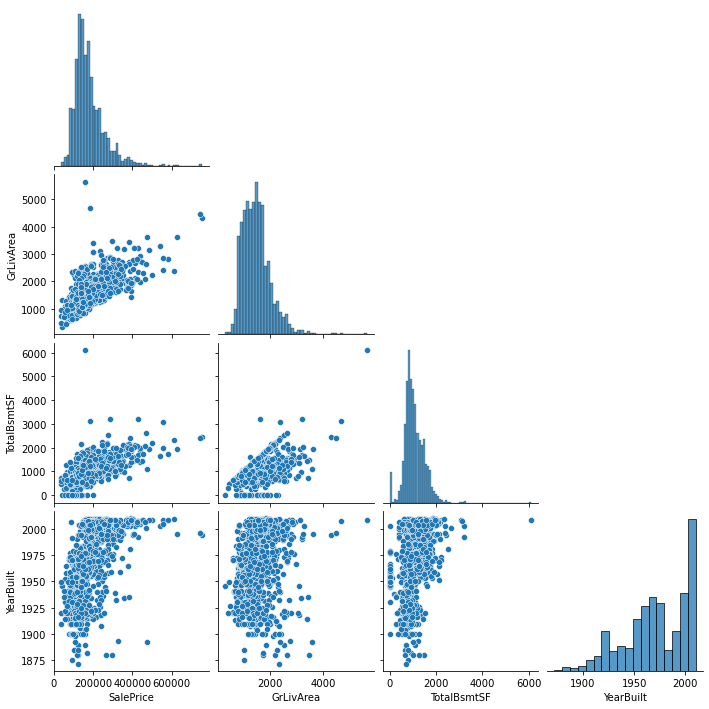

In [4]:
lst = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt'] #'OverallQual',
sns.pairplot(data=df[lst], corner=True);

'SalePrice', 'GrLiveArea', 'TotalBsmtSf' have skewed distribution. Let's transform them to make them look more normal

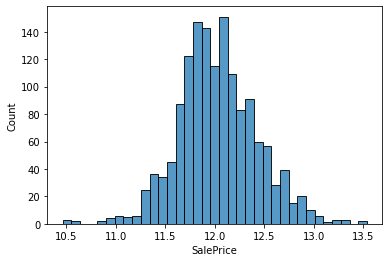

In [5]:
sns.histplot(np.log(df['SalePrice']));

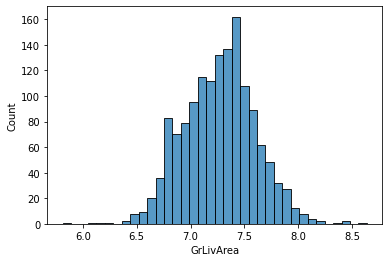

In [6]:
sns.histplot(np.log(df['GrLivArea']));


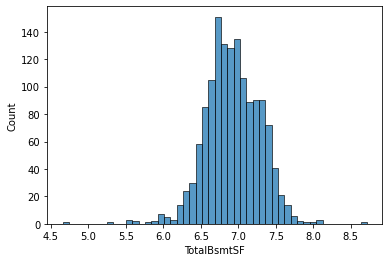

In [7]:
# we can't apply log-transform directly to TotalBsmtSF? because it contains 0-s
df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
mask_bsmt = df['TotalBsmtSF'] > 0
sns.histplot(np.log(df.loc[mask_bsmt, 'TotalBsmtSF']));

In [8]:
df.loc[:, 'SalePrice'] = np.log(df['SalePrice'])
df.loc[:, 'GrLivArea'] = np.log(df['GrLivArea'])
df.loc[:, 'TotalBsmtSF'] = df['TotalBsmtSF'].transform(lambda x: np.log(x) if  x>0 else 0)

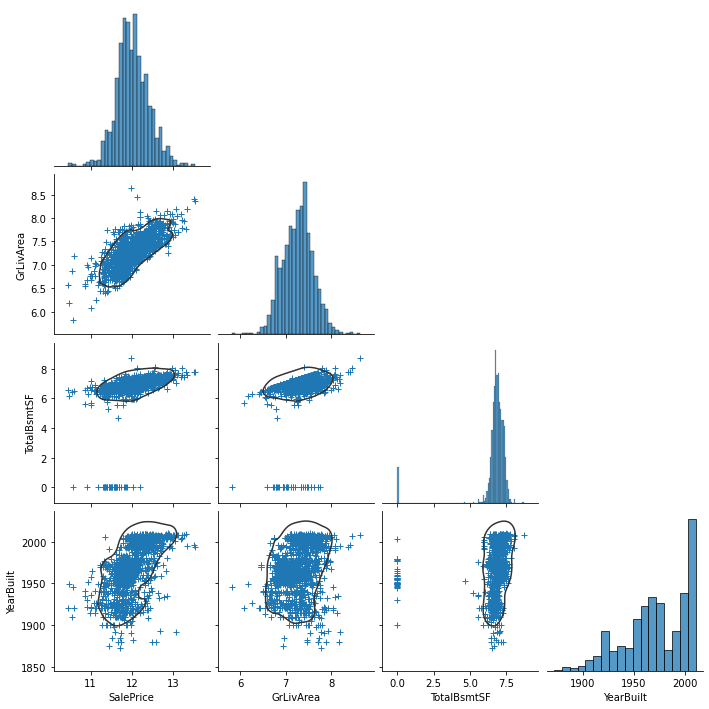

In [9]:
g = sns.pairplot(data=df[lst], plot_kws=dict(marker="+", linewidth=1), corner=True);
g.map_lower(sns.kdeplot, levels=[0.1], color=".2")

# Anomalies detection

In [10]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import f
from numpy.linalg import inv


def mahalanobis_distances(data):
    n = data.shape[0]
    maha_distances = np.zeros(n)
    for i in range(n):
        x_i = data.iloc[i]
        data_i = data.drop(data.index[i])
        m_i = np.mean(data_i)
        inv_cov = inv(np.cov(data_i, rowvar=False))
        maha_distances[i] = mahalanobis(x_i, m_i, inv_cov)
    return maha_distances
  
# returns i_0 - index of anomaly (in DataFrame)
#         or None, if no anomalies were found  
def find_anomaly(data, alpha=0.01):
    maha_distances = mahalanobis_distances(data)  
    
    n, q = data.shape
    Fstat = (n-1)*(n-1-q)/(n*(n-2)*q) * maha_distances**2
    i_0 = np.argmax(Fstat)
    
    dfn, dfd = q, n-1-q
    F_alpha = f.ppf(1-alpha, dfn, dfd)
    
    p_value = 1-f.cdf(Fstat[i_0],  dfn, dfd)
    
#     print('Fstat_i_0 = {:.2e}, F_alpha = {:.2e}'.format(Fstat_i, F_alpha))
    if Fstat[i_0] > F_alpha:
        print("{} : A, p-value = {:.2e}, where alpha = {:.2e}".format(data.index[i_0], p_value, alpha))
        return data.index[i_0]
    else:
        print("{} : NOT A, p-value = {:.2e}, where alpha = {:.2e}".format(data.index[i_0], p_value, alpha))
        return None

# returns: df, anomalies        
def remove_anomalies(data, columns, alpha):
    anomalies = []
    found = True
    while found:
        i_0 = find_anomaly(data[columns], alpha)
        found = bool(i_0)
        if found:
            anomalies.append(data[columns].loc[i_0].tolist())
            data = data.drop(i_0)
    return data, np.array(anomalies)
            
df, anomalies_gr = remove_anomalies(data=df, 
                                    columns=['SalePrice', 'GrLivArea'],
                                    alpha=1e-3)
data = df[df['TotalBsmtSF'] > 0]
data, anomalies_tot = remove_anomalies(data,
                                        columns=['SalePrice', 'TotalBsmtSF'],
                                        alpha=1e-3)
df.loc[df['TotalBsmtSF'] > 0] = data
df = df.dropna()
df.shape

1299 : A, p-value = 5.69e-09, where alpha = 1.00e-03
31 : A, p-value = 3.38e-06, where alpha = 1.00e-03
524 : A, p-value = 3.25e-06, where alpha = 1.00e-03
534 : A, p-value = 4.99e-05, where alpha = 1.00e-03
969 : A, p-value = 5.86e-05, where alpha = 1.00e-03
1063 : A, p-value = 1.25e-04, where alpha = 1.00e-03
496 : A, p-value = 1.60e-04, where alpha = 1.00e-03
917 : A, p-value = 3.09e-04, where alpha = 1.00e-03
1183 : A, p-value = 4.02e-04, where alpha = 1.00e-03
692 : A, p-value = 3.86e-04, where alpha = 1.00e-03
1293 : NOT A, p-value = 1.02e-03, where alpha = 1.00e-03
873 : A, p-value = 1.14e-12, where alpha = 1.00e-03
495 : A, p-value = 2.34e-06, where alpha = 1.00e-03
741 : A, p-value = 4.62e-05, where alpha = 1.00e-03
491 : A, p-value = 9.92e-05, where alpha = 1.00e-03
411 : A, p-value = 3.23e-04, where alpha = 1.00e-03
711 : A, p-value = 3.62e-04, where alpha = 1.00e-03
637 : A, p-value = 3.60e-04, where alpha = 1.00e-03
112 : A, p-value = 8.50e-04, where alpha = 1.00e-03
1101 

(1441, 34)

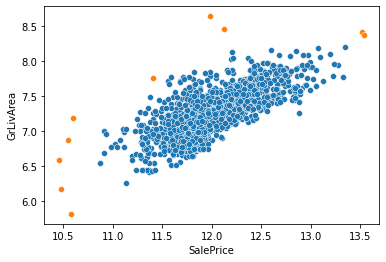

In [11]:
# sns.kdeplot(data=df, x='SalePrice', y='GrLivArea', levels=10)
sns.scatterplot(data=df, x='SalePrice', y='GrLivArea')
sns.scatterplot(x=anomalies_gr[:, 0], y=anomalies_gr[:, 1])

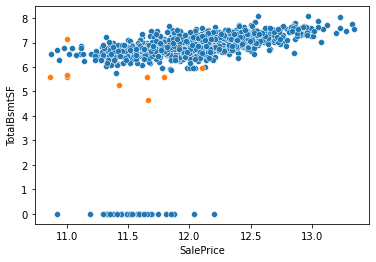

In [12]:
# sns.kdeplot(data=df, x='SalePrice', y='TotalBsmtSF', levels=10)
sns.scatterplot(data=df, x='SalePrice', y='TotalBsmtSF')
sns.scatterplot(x=anomalies_tot[:, 0], y=anomalies_tot[:, 1])

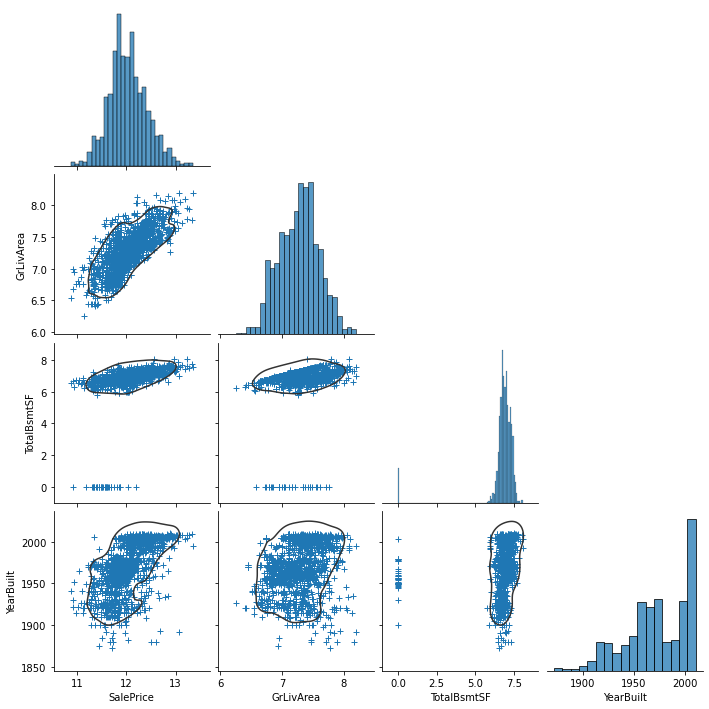

In [13]:
lst = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt'] #'OverallQual',
g = sns.pairplot(data=df[lst], plot_kws=dict(marker="+", linewidth=1), corner=True);
g.map_lower(sns.kdeplot, levels=[0.1], color=".2")

# Summary

In [14]:
df.shape

(1441, 34)

In [15]:
df.to_csv('preprocessed2_' + fname)